#BA870 - Using BERT to Predict a Company's Asset Intensity (Text Analysis)

In [ ]:
!pip install transformers

# 1. Install, load the libraries

In [ ]:
import numpy as np
import pandas as pd
import torch
import transformers as ppb # pytorch transformers
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
print('Device:', torch.device('cuda:0'))

Device: cuda:0


# 2. Upload data files

In [ ]:
# load the csv files
stock_des = pd.read_csv('stock_des.csv')
financial_ratios = pd.read_csv('financial_ratios.csv')

# 3. Merge and clean the data

In [ ]:
# merge the dataframes into one
df = pd.merge(financial_ratios, stock_des, on='ticker')

In [ ]:
df

,ticker,total_assets,total_debt,total_liability,op_inc_bef_dep,sale,total_equity,mark_value,description
0,AIR,1833.100,317.900,734.000,179.300,1990.600,1099.100,1749.6408,AAR Corp. provides products and services to co...
1,AAL,63058.000,35722.000,68260.000,6267.000,52788.000,-5202.000,8989.7110,"American Airlines Group Inc., through its subs..."
2,PNW,24661.153,8750.811,18376.291,1618.683,4695.991,6284.862,8148.4520,"Pinnacle West Capital Corporation, through its..."
3,PRG,1491.255,608.114,899.924,1849.328,2408.264,591.331,1349.9633,"PROG Holdings, Inc. operates as an omnichannel..."
4,ABT,73214.000,14548.000,34387.000,10036.000,40109.000,38827.000,190869.7453,"Abbott Laboratories discovers, develops, manuf..."
...,...,...,...,...,...,...,...,...,...
2385,APG,7590.000,2494.000,4722.000,771.000,6928.000,2868.000,8150.8950,"APi Group Corporation provides safety, special..."
2386,NVT,6161.700,1847.200,3019.600,772.300,3263.600,3142.100,9753.9272,"nVent Electric plc designs, manufactures, mark..."
2387,ACA,3577.900,591.600,1245.900,339.400,2307.900,2332.000,4016.3040,"Arcosa, Inc., together with its subsidiaries, ..."
2388,HYFM,507.643,171.652,217.033,-4.848,226.581,290.610,42.0123,"Hydrofarm Holdings Group, Inc., together with ..."


In [ ]:
df.isnull().sum()

ticker               0
total_assets         4
total_debt          10
total_liability     10
op_inc_bef_dep     127
sale                 4
total_equity         4
mark_value          12
description          0
dtype: int64

In [ ]:
df.dropna(inplace=True)

# **I. Debt-Equity Ratio**

In [ ]:
df1 = df[['ticker', 'total_debt', 'total_equity', 'description']]

In [ ]:
df1

,ticker,total_debt,total_equity,description
0,AIR,317.900,1099.100,AAR Corp. provides products and services to co...
1,AAL,35722.000,-5202.000,"American Airlines Group Inc., through its subs..."
2,PNW,8750.811,6284.862,"Pinnacle West Capital Corporation, through its..."
3,PRG,608.114,591.331,"PROG Holdings, Inc. operates as an omnichannel..."
4,ABT,14548.000,38827.000,"Abbott Laboratories discovers, develops, manuf..."
...,...,...,...,...
2385,APG,2494.000,2868.000,"APi Group Corporation provides safety, special..."
2386,NVT,1847.200,3142.100,"nVent Electric plc designs, manufactures, mark..."
2387,ACA,591.600,2332.000,"Arcosa, Inc., together with its subsidiaries, ..."
2388,HYFM,171.652,290.610,"Hydrofarm Holdings Group, Inc., together with ..."


<ipython-input-262-8d39ed90a771>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['debt_equity'] = df1['total_debt']/df1['total_equity']


count    2249.000000
mean        0.778481
std         7.012617
min      -206.612332
25%         0.113251
50%         0.454464
75%         1.047037
max       126.075608
Name: debt_equity, dtype: float64


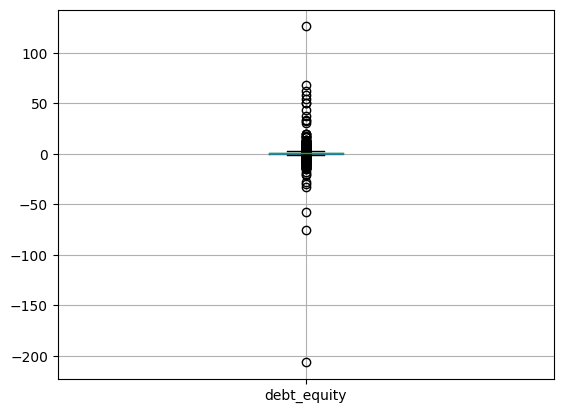

In [ ]:
df1['debt_equity'] = df1['total_debt']/df1['total_equity']
print(df1['debt_equity'].describe())
df1.boxplot(column='debt_equity');

##Removing the outliers

In [ ]:
df1 = df1[(df1['debt_equity'] > -50) & (df1['debt_equity'] <= 100)]
print(df1.shape)

(2245, 5)


##Create a binary variable that is 1 if the debt equity ratio is above 2 and 0 otherwise.

In [ ]:
df1['high_debt_equity'] = (df1['debt_equity'] >= 2).astype(int)
# Display the DataFrame
df1

,ticker,total_debt,total_equity,description,debt_equity,high_debt_equity,token_count,text
0,PGNY,17.241,553.429,"Progyny, Inc., a benefits management company, ...",0.031153,0,123,"Progyny, Inc., a benefits management company, ..."
1,FOXF,812.765,1221.761,"Fox Factory Holding Corp. designs, engineers, ...",0.665241,0,192,"Fox Factory Holding Corp. designs, engineers, ..."
2,INSP,24.846,572.514,"Inspire Medical Systems, Inc., a medical techn...",0.043398,0,105,"Inspire Medical Systems, Inc., a medical techn..."
3,LUV,8963.000,10515.000,Southwest Airlines Co. operates as a passenger...,0.852401,0,248,Southwest Airlines Co. operates as a passenger...
4,SRPT,1273.480,859.337,"Sarepta Therapeutics, Inc., a commercial-stage...",1.481933,0,249,"Sarepta Therapeutics, Inc., a commercialstage ..."
...,...,...,...,...,...,...,...,...
1995,TRUE,11.169,160.215,"TrueCar, Inc. operates as an internet-based in...",0.069713,0,241,"TrueCar, Inc. operates as an internetbased inf..."
1996,VAPO,109.978,-55.334,"Vapotherm, Inc., a medical technology company,...",-1.987530,0,235,"Vapotherm, Inc., a medical technology company,..."
1997,LYV,7145.117,587.157,"Live Nation Entertainment, Inc. operates as a ...",12.169006,1,324,"Live Nation Entertainment, Inc. operates as a ..."
1998,VRNS,301.790,489.648,"Varonis Systems, Inc. provides software produc...",0.616341,0,313,"Varonis Systems, Inc. provides software produc..."


In [ ]:
df1=df1.sample(2000, random_state=6887)
df1=df1.reset_index(drop=True)

In [ ]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
# Count the number of tokens in the 'text' column
df1['token_count'] = df1['description'].apply(lambda x: len(word_tokenize(x)))
print(df1.shape)
df1

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(2000, 7)


,ticker,total_debt,total_equity,description,debt_equity,high_debt_equity,token_count
0,PGNY,17.241,553.429,"Progyny, Inc., a benefits management company, ...",0.031153,0,123
1,FOXF,812.765,1221.761,"Fox Factory Holding Corp. designs, engineers, ...",0.665241,0,192
2,INSP,24.846,572.514,"Inspire Medical Systems, Inc., a medical techn...",0.043398,0,105
3,LUV,8963.000,10515.000,Southwest Airlines Co. operates as a passenger...,0.852401,0,248
4,SRPT,1273.480,859.337,"Sarepta Therapeutics, Inc., a commercial-stage...",1.481933,0,249
...,...,...,...,...,...,...,...
1995,TRUE,11.169,160.215,"TrueCar, Inc. operates as an internet-based in...",0.069713,0,241
1996,VAPO,109.978,-55.334,"Vapotherm, Inc., a medical technology company,...",-1.987530,0,235
1997,LYV,7145.117,587.157,"Live Nation Entertainment, Inc. operates as a ...",12.169006,1,324
1998,VRNS,301.790,489.648,"Varonis Systems, Inc. provides software produc...",0.616341,0,313


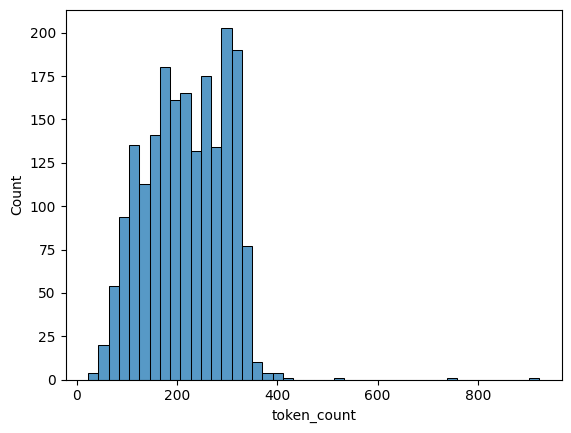

In [ ]:
import seaborn as sns
sns.histplot(data=df1, x="token_count");

In [ ]:
import re
# Function to remove unusual characters
def remove_unusual_characters(text):
    pattern = r'[^a-zA-Z0-9.,?! ]'  # Pattern to match common English characters, numbers, and punctuation
    text = re.sub(pattern, '', text)
    return text

# Apply the function to the 'text' column
df1['text'] = df1['description'].apply(remove_unusual_characters)

In [ ]:
# Remove very long descriptions
lower_threshold1 = df1['token_count'].quantile(0.00)
upper_threshold1 = df1['token_count'].quantile(0.99)

# Trim the DataFrame based on the 1% thresholds
trimmed_df1 = df1[(df1['token_count'] >= lower_threshold1) & (df1['token_count'] <= upper_threshold1)]

trimmed_df1

,ticker,total_debt,total_equity,description,debt_equity,high_debt_equity,token_count,text
0,PGNY,17.241,553.429,"Progyny, Inc., a benefits management company, ...",0.031153,0,123,"Progyny, Inc., a benefits management company, ..."
1,FOXF,812.765,1221.761,"Fox Factory Holding Corp. designs, engineers, ...",0.665241,0,192,"Fox Factory Holding Corp. designs, engineers, ..."
2,INSP,24.846,572.514,"Inspire Medical Systems, Inc., a medical techn...",0.043398,0,105,"Inspire Medical Systems, Inc., a medical techn..."
3,LUV,8963.000,10515.000,Southwest Airlines Co. operates as a passenger...,0.852401,0,248,Southwest Airlines Co. operates as a passenger...
4,SRPT,1273.480,859.337,"Sarepta Therapeutics, Inc., a commercial-stage...",1.481933,0,249,"Sarepta Therapeutics, Inc., a commercialstage ..."
...,...,...,...,...,...,...,...,...
1995,TRUE,11.169,160.215,"TrueCar, Inc. operates as an internet-based in...",0.069713,0,241,"TrueCar, Inc. operates as an internetbased inf..."
1996,VAPO,109.978,-55.334,"Vapotherm, Inc., a medical technology company,...",-1.987530,0,235,"Vapotherm, Inc., a medical technology company,..."
1997,LYV,7145.117,587.157,"Live Nation Entertainment, Inc. operates as a ...",12.169006,1,324,"Live Nation Entertainment, Inc. operates as a ..."
1998,VRNS,301.790,489.648,"Varonis Systems, Inc. provides software produc...",0.616341,0,313,"Varonis Systems, Inc. provides software produc..."


In [ ]:
trimmed_df1=trimmed_df1[trimmed_df1["ticker"]!="LLY"] # these 2 have special characters in description, hence removed
trimmed_df1=trimmed_df1[trimmed_df1["ticker"]!="BIIB"]
trimmed_df1=trimmed_df1.reset_index(drop=True)

In [ ]:
from nltk.tokenize import sent_tokenize
# Function to keep first three sentences
def keep_n_sentences(text):
    sentences = sent_tokenize(text)
    first_three_sentences = sentences[:1]
    return ' '.join(first_three_sentences)

# Apply the function to the 'text' column
trimmed_df1['text'] = trimmed_df1['text'].apply(keep_n_sentences)

In [ ]:
trimmed_df1.head(3)

,ticker,total_debt,total_equity,description,debt_equity,high_debt_equity,token_count,text
0,PGNY,17.241,553.429,"Progyny, Inc., a benefits management company, ...",0.031153,0,123,"Progyny, Inc., a benefits management company, ..."
1,FOXF,812.765,1221.761,"Fox Factory Holding Corp. designs, engineers, ...",0.665241,0,192,"Fox Factory Holding Corp. designs, engineers, ..."
2,INSP,24.846,572.514,"Inspire Medical Systems, Inc., a medical techn...",0.043398,0,105,"Inspire Medical Systems, Inc., a medical techn..."


##Preparing the predictor and DistilBERT model

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights, max_length=2)
model = model_class.from_pretrained(pretrained_weights)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

##Tokenize the textual data for DistilBERT.

In [ ]:
trimmed_df1.description[12]

'Lakeland Financial Corporation operates as the bank holding company for Lake City Bank that provides various banking products and services. The company accepts various deposit products, such as noninterest bearing, interest-bearing checking, savings, money market, NOW, and demand deposits. Its loan products include commercial and industrial, commercial real estate and multi-family residential, agri-business and agricultural, consumer 1-4 family mortgage, and other consumer loans. The company also offers retail and merchant credit card services; corporate treasury management, wealth advisory, and trust services; retail brokerage services, including various financial and investment products, such as annuities and life insurance; and internet business banking and on-line treasury management services. It serves commercial real estate, manufacturing, agriculture, construction, retail, wholesale, finance and insurance, accommodation and food services, and health care industries. As of Decem

In [ ]:
trimmed_df1.text[12]

'Lakeland Financial Corporation operates as the bank holding company for Lake City Bank that provides various banking products and services.'

In [ ]:
tokenized1 = trimmed_df1['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

##Pad all lists of tokenized values to the same size.

In [ ]:
max_len = 0
for i in tokenized1.values:
    if len(i) > max_len:
        max_len = len(i)

padded1 = np.array([i + [0]*(max_len-len(i)) for i in tokenized1.values])

In [ ]:
np.array(padded1).shape

(1979, 100)

In [ ]:
attention_mask = np.where(padded1 != 0, 1, 0)
attention_mask.shape

(1979, 100)

## DistilBERT model

In [ ]:
input_ids = torch.tensor(padded1)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids,
                               attention_mask=attention_mask)

<ipython-input-230-29c3424b024b>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(attention_mask)


## Logistic regression model


In [ ]:
trimmed_df1

,ticker,total_debt,total_equity,description,debt_equity,high_debt_equity,token_count,text
0,PGNY,17.241,553.429,"Progyny, Inc., a benefits management company, ...",0.031153,0,123,"Progyny, Inc., a benefits management company, ..."
1,FOXF,812.765,1221.761,"Fox Factory Holding Corp. designs, engineers, ...",0.665241,0,192,"Fox Factory Holding Corp. designs, engineers, ..."
2,INSP,24.846,572.514,"Inspire Medical Systems, Inc., a medical techn...",0.043398,0,105,"Inspire Medical Systems, Inc., a medical techn..."
3,LUV,8963.000,10515.000,Southwest Airlines Co. operates as a passenger...,0.852401,0,248,Southwest Airlines Co. operates as a passenger...
4,SRPT,1273.480,859.337,"Sarepta Therapeutics, Inc., a commercial-stage...",1.481933,0,249,"Sarepta Therapeutics, Inc., a commercialstage ..."
...,...,...,...,...,...,...,...,...
1974,TRUE,11.169,160.215,"TrueCar, Inc. operates as an internet-based in...",0.069713,0,241,"TrueCar, Inc. operates as an internetbased inf..."
1975,VAPO,109.978,-55.334,"Vapotherm, Inc., a medical technology company,...",-1.987530,0,235,"Vapotherm, Inc., a medical technology company,..."
1976,LYV,7145.117,587.157,"Live Nation Entertainment, Inc. operates as a ...",12.169006,1,324,"Live Nation Entertainment, Inc. operates as a ..."
1977,VRNS,301.790,489.648,"Varonis Systems, Inc. provides software produc...",0.616341,0,313,"Varonis Systems, Inc. provides software produc..."


In [ ]:
features1 = last_hidden_states[0][:,0,:].numpy()
labels1 = trimmed_df1['high_debt_equity']

In [ ]:
features1

array([[-0.4685655 , -0.15254568, -0.26088962, ..., -0.1099144 ,
         0.29823437,  0.52396923],
       [-0.3924973 , -0.21256879, -0.14517824, ..., -0.29499143,
         0.29298133,  0.3116078 ],
       [-0.48038805, -0.18228008, -0.28914028, ..., -0.09028091,
         0.25982305,  0.3063024 ],
       ...,
       [-0.28240833, -0.05231728, -0.13909516, ..., -0.05405312,
         0.5296694 ,  0.33160532],
       [-0.3738006 , -0.1388223 , -0.33005032, ..., -0.08191945,
         0.42910266,  0.49709412],
       [-0.24719869, -0.00574954, -0.16402751, ...,  0.09633833,
         0.5788754 ,  0.36579853]], dtype=float32)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features1, labels1, random_state=42)
lr_der = LogisticRegression(max_iter=5000)
lr_der.fit(train_features, train_labels)
print(lr_der.score(test_features, test_labels))

0.8868686868686869


In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.881 (+/- 0.00)


##Analysis of Debt Equity Ratio Model

**Debt Equity Ratio** - The debt-to-equity (D/E) ratio is used to evaluate a company’s financial leverage and is calculated by dividing a company’s total liabilities by its shareholder equity. The D/E ratio is an important metric in corporate finance. It is a measure of the degree to which a company is financing its operations with debt rather than its own resources.

- The debt-to-equity (D/E) ratio compares a company’s total liabilities with its shareholder equity and can be used to assess the extent of its reliance on debt.
- D/E ratios vary by industry and are best used to compare direct competitors or to measure change in the company’s reliance on debt over time.
- Among similar companies, a higher D/E ratio suggests more risk, while a particularly low one may indicate that a business is not taking advantage of debt financing to expand.
- What counts as a “good” debt-to-equity (D/E) ratio will depend on the nature of the business and its industry. Generally speaking, a D/E ratio below 1 would be seen as relatively safe, whereas values of 2 or higher might be considered risky. Companies in some industries, such as utilities, consumer staples, and banking, typically have relatively high D/E ratios.

From the boxplot, in the dataset around 4 outliers have been dropped.
For calculating high debt ratio variable, we filter it on the basis when debt equity ratio is more than 2.

**Perfomance Evaluation** -
The logistic regression model achieves an accuracy of approximately 88.7% on the test set. Accuracy measures the proportion of correctly predicted instances out of the total number of instances in the test set. A high accuracy indicates that the model is effective at distinguishing between high and low debt-to-equity ratios based on textual descriptions.

# **II.Price to Sales Ratio**

In [ ]:
df2 = df[['ticker', 'mark_value', 'sale', 'description']]

count    2249.000000
mean             inf
std              NaN
min       -22.567933
25%         0.909738
50%         1.871323
75%         3.876039
max              inf
Name: price_sales, dtype: float64


<ipython-input-168-290a55e89da3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['price_sales'] = df2['mark_value']/df['sale']


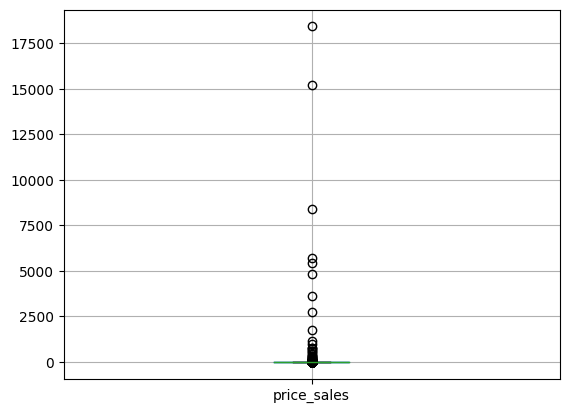

In [ ]:
df2['price_sales'] = df2['mark_value']/df['sale']
print(df2['price_sales'].describe())
df2.boxplot(column='price_sales');

## Removing the outliers

In [ ]:
df2 = df2[(df2['price_sales'] < 2500)]
print(df2.shape)

(2184, 5)


## Creating a binary variable that is 1 if the debt equity ratio is above 2 and 0 otherwise

In [ ]:
df2['high_price_sales'] = (df2['price_sales'].gt(df2['price_sales'].median())).astype(int)
# Display the DataFrame
df2

,ticker,mark_value,sale,description,price_sales,high_price_sales
0,AIR,1749.6408,1990.600,AAR Corp. provides products and services to co...,0.878951,0
1,AAL,8989.7110,52788.000,"American Airlines Group Inc., through its subs...",0.170298,0
2,PNW,8148.4520,4695.991,"Pinnacle West Capital Corporation, through its...",1.735193,0
3,PRG,1349.9633,2408.264,"PROG Holdings, Inc. operates as an omnichannel...",0.560555,0
4,ABT,190869.7453,40109.000,"Abbott Laboratories discovers, develops, manuf...",4.758776,1
...,...,...,...,...,...,...
2384,LPG,805.2370,392.151,"Dorian LPG Ltd., together with its subsidiarie...",2.053385,1
2385,APG,8150.8950,6928.000,"APi Group Corporation provides safety, special...",1.176515,0
2386,NVT,9753.9272,3263.600,"nVent Electric plc designs, manufactures, mark...",2.988702,1
2387,ACA,4016.3040,2307.900,"Arcosa, Inc., together with its subsidiaries, ...",1.740242,0


In [ ]:
df2=df2.sample(2000, random_state=6887)
df2=df2.reset_index(drop=True)

In [ ]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
# Count the number of tokens in the 'text' column
df2['token_count'] = df2['description'].apply(lambda x: len(word_tokenize(x)))
print(df2.shape)
df2

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(2000, 7)


,ticker,mark_value,sale,description,price_sales,high_price_sales,token_count
0,APEI,169.8786,600.545,"American Public Education, Inc., together with...",0.282874,0,125
1,NVEC,400.9247,38.254,NVE Corporation develops and sells devices tha...,10.480595,1,140
2,TWLO,13804.2430,4153.945,"Twilio Inc., together with its subsidiaries, p...",3.323165,1,96
3,ZYXI,358.6513,184.322,"Zynex, Inc., through its subsidiaries, designs...",1.945787,1,224
4,NYCB,7386.7352,6047.000,"New York Community Bancorp, Inc. operates as t...",1.221554,0,211
...,...,...,...,...,...,...,...
1995,CASH,1206.8206,705.334,"Meta Financial Group, Inc. operates as the hol...",1.710992,0,210
1996,APPS,1229.3009,665.920,"Digital Turbine, Inc., through its subsidiarie...",1.846019,1,89
1997,DD,33088.3623,12068.000,"DuPont de Nemours, Inc. provides technology-ba...",2.741827,1,293
1998,ARQT,312.6220,59.606,"Arcutis Biotherapeutics, Inc., a biopharmaceut...",5.244808,1,147


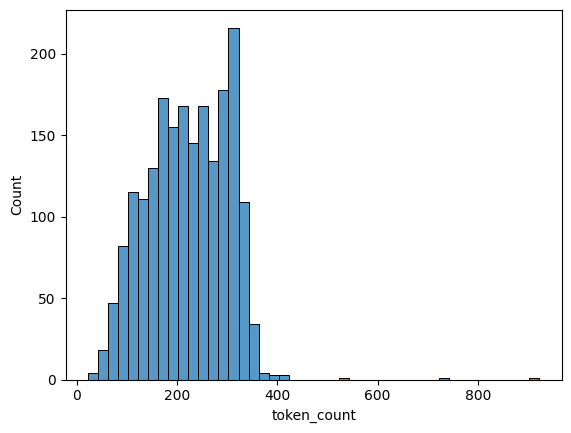

In [ ]:
import seaborn as sns
sns.histplot(data=df2, x="token_count");

In [ ]:
import re
# Function to remove unusual characters
def remove_unusual_characters(text):
    pattern = r'[^a-zA-Z0-9.,?! ]'  # Pattern to match common English characters, numbers, and punctuation
    text = re.sub(pattern, '', text)
    return text

# Apply the function to the 'text' column
df2['text'] = df2['description'].apply(remove_unusual_characters)

In [ ]:
# Remove very long descriptions
lower_threshold = df2['token_count'].quantile(0.00)
upper_threshold = df2['token_count'].quantile(0.99)

# Trim the DataFrame based on the 1% thresholds
trimmed_df2 = df2[(df2['token_count'] >= lower_threshold) & (df2['token_count'] <= upper_threshold)]

trimmed_df2

,ticker,mark_value,sale,description,price_sales,high_price_sales,token_count,text
0,APEI,169.8786,600.545,"American Public Education, Inc., together with...",0.282874,0,125,"American Public Education, Inc., together with..."
1,NVEC,400.9247,38.254,NVE Corporation develops and sells devices tha...,10.480595,1,140,NVE Corporation develops and sells devices tha...
2,TWLO,13804.2430,4153.945,"Twilio Inc., together with its subsidiaries, p...",3.323165,1,96,"Twilio Inc., together with its subsidiaries, p..."
3,ZYXI,358.6513,184.322,"Zynex, Inc., through its subsidiaries, designs...",1.945787,1,224,"Zynex, Inc., through its subsidiaries, designs..."
4,NYCB,7386.7352,6047.000,"New York Community Bancorp, Inc. operates as t...",1.221554,0,211,"New York Community Bancorp, Inc. operates as t..."
...,...,...,...,...,...,...,...,...
1995,CASH,1206.8206,705.334,"Meta Financial Group, Inc. operates as the hol...",1.710992,0,210,"Meta Financial Group, Inc. operates as the hol..."
1996,APPS,1229.3009,665.920,"Digital Turbine, Inc., through its subsidiarie...",1.846019,1,89,"Digital Turbine, Inc., through its subsidiarie..."
1997,DD,33088.3623,12068.000,"DuPont de Nemours, Inc. provides technology-ba...",2.741827,1,293,"DuPont de Nemours, Inc. provides technologybas..."
1998,ARQT,312.6220,59.606,"Arcutis Biotherapeutics, Inc., a biopharmaceut...",5.244808,1,147,"Arcutis Biotherapeutics, Inc., a biopharmaceut..."


In [ ]:
trimmed_df2=trimmed_df2[trimmed_df2["ticker"]!="LLY"] # these 2 have special characters in description, hence removed
trimmed_df2=trimmed_df2[trimmed_df2["ticker"]!="BIIB"]
trimmed_df2=trimmed_df2.reset_index(drop=True)

In [ ]:
from nltk.tokenize import sent_tokenize
# Function to keep first three sentences
def keep_n_sentences(text):
    sentences = sent_tokenize(text)
    first_three_sentences = sentences[:1]
    return ' '.join(first_three_sentences)

# Apply the function to the 'text' column
trimmed_df2['text'] = trimmed_df2['text'].apply(keep_n_sentences)

In [ ]:
trimmed_df2.head(3)

,ticker,mark_value,sale,description,price_sales,high_price_sales,token_count,text
0,APEI,169.8786,600.545,"American Public Education, Inc., together with...",0.282874,0,125,"American Public Education, Inc., together with..."
1,NVEC,400.9247,38.254,NVE Corporation develops and sells devices tha...,10.480595,1,140,NVE Corporation develops and sells devices tha...
2,TWLO,13804.2430,4153.945,"Twilio Inc., together with its subsidiaries, p...",3.323165,1,96,"Twilio Inc., together with its subsidiaries, p..."


##Preparing the predictor and DistilBERT model

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights, max_length=2)
model = model_class.from_pretrained(pretrained_weights)

## Tokenize the textual data for DistilBERT

In [ ]:
trimmed_df2.description[12]

"MKS Instruments, Inc. provides instruments, systems, subsystems, and process control solutions that measure, monitor, deliver, analyze, power, and control critical parameters of manufacturing processes worldwide. Its Vacuum &amp; Analysis segment offers pressure and vacuum control solutions, including direct and indirect pressure measurement; materials delivery solutions comprising flow and valve technologies, as well as integrated pressure measurement and control subsystems, which provide customers with precise control capabilities; power delivery products, such as microwave, power delivery systems, radio frequency matching networks, and metrology products used in providing energy to etching, stripping, and deposition processes; and plasma and reactive gas products. The company's Light &amp; Motion segment offers laser-based systems, such as amplifiers, fiber lasers, diode-pumped solid-state lasers, high-energy pulsed lasers, and tunable lasers; and photonics products comprising opti

In [ ]:
trimmed_df2.text[12]

'MKS Instruments, Inc. provides instruments, systems, subsystems, and process control solutions that measure, monitor, deliver, analyze, power, and control critical parameters of manufacturing processes worldwide.'

In [ ]:
tokenized2 = trimmed_df2['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

##Pad all lists of tokenized values to the same size.

In [ ]:
max_len = 0
for i in tokenized2.values:
    if len(i) > max_len:
        max_len = len(i)

padded2 = np.array([i + [0]*(max_len-len(i)) for i in tokenized2.values])

In [ ]:
np.array(padded2).shape

(1978, 100)

In [ ]:
attention_mask = np.where(padded2 != 0, 1, 0)
attention_mask.shape

(1978, 100)

## DistilBERT model

In [ ]:
input_ids = torch.tensor(padded2)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids,
                               attention_mask=attention_mask)

## Logistic Regression Model

In [ ]:
trimmed_df2

,ticker,mark_value,sale,description,price_sales,high_price_sales,token_count,text
0,APEI,169.8786,600.545,"American Public Education, Inc., together with...",0.282874,0,125,"American Public Education, Inc., together with..."
1,NVEC,400.9247,38.254,NVE Corporation develops and sells devices tha...,10.480595,1,140,NVE Corporation develops and sells devices tha...
2,TWLO,13804.2430,4153.945,"Twilio Inc., together with its subsidiaries, p...",3.323165,1,96,"Twilio Inc., together with its subsidiaries, p..."
3,ZYXI,358.6513,184.322,"Zynex, Inc., through its subsidiaries, designs...",1.945787,1,224,"Zynex, Inc., through its subsidiaries, designs..."
4,NYCB,7386.7352,6047.000,"New York Community Bancorp, Inc. operates as t...",1.221554,0,211,"New York Community Bancorp, Inc. operates as t..."
...,...,...,...,...,...,...,...,...
1973,CASH,1206.8206,705.334,"Meta Financial Group, Inc. operates as the hol...",1.710992,0,210,"Meta Financial Group, Inc. operates as the hol..."
1974,APPS,1229.3009,665.920,"Digital Turbine, Inc., through its subsidiarie...",1.846019,1,89,"Digital Turbine, Inc., through its subsidiarie..."
1975,DD,33088.3623,12068.000,"DuPont de Nemours, Inc. provides technology-ba...",2.741827,1,293,"DuPont de Nemours, Inc. provides technologybas..."
1976,ARQT,312.6220,59.606,"Arcutis Biotherapeutics, Inc., a biopharmaceut...",5.244808,1,147,"Arcutis Biotherapeutics, Inc., a biopharmaceut..."


In [ ]:
features2 = last_hidden_states[0][:,0,:].numpy()
labels2 = trimmed_df2['high_price_sales']

In [ ]:
features2

array([[-0.40798783,  0.06268565, -0.23948258, ...,  0.04909059,
         0.71584725,  0.69119495],
       [-0.35694137, -0.015841  , -0.36541313, ...,  0.06504769,
         0.37376833,  0.30767295],
       [-0.44626775,  0.03156462, -0.27658355, ..., -0.07906241,
         0.22291031,  0.3512324 ],
       ...,
       [-0.33179832, -0.05417881, -0.39929795, ..., -0.23532516,
         0.3245431 ,  0.38818708],
       [-0.42286968,  0.00403621, -0.40493256, ..., -0.02319802,
         0.41440845,  0.54521793],
       [-0.5771654 , -0.03772489, -0.21217439, ..., -0.15757403,
         0.15102492,  0.4293064 ]], dtype=float32)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features2, labels2, random_state=42)
lr_psr = LogisticRegression(max_iter=5000)
lr_psr.fit(train_features, train_labels)
print(lr_psr.score(test_features, test_labels))

0.6686868686868687


In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.504 (+/- 0.00)


## Analysis of Price to Sales Ratio

In this model the price variable has been taken as the market value which describes as Market value for single issue companies is common shares outstanding multiplied by the month-end price that corresponds to the period end date.

The price-to-sales (P/S) ratio is a valuation ratio that compares a company’s stock price to its revenues. It is an indicator of the value that financial markets have placed on each dollar of a company’s sales or revenues.

- The price-to-sales (P/S) ratio shows how much investors are willing to pay per dollar of sales for a stock.
- A low ratio could imply the stock is undervalued, while a ratio that is higher-than-average could indicate that the stock is overvalued.
- One of the downsides of the P/S ratio is that it doesn’t take into account whether the company makes any earnings or whether it will ever make earnings.

From the boxplot, in the dataset around 8 outliers have been dropped.
For calculating high price to sales variable, we filter it on the basis median to get a balanced proportioned.

**Performance Evaluation:**
The logistic regression model achieves an accuracy of approximately 66.9% on the test set. Accuracy measures the proportion of correctly predicted instances out of the total number of instances in the test set. While this accuracy indicates that the model performs better than random guessing, it suggests that there is room for improvement in distinguishing between companies with high and low price-to-sales ratios based on textual descriptions alone.



# **III.Return on Assets**

In [ ]:
df3 = df[['ticker', 'op_inc_bef_dep', 'total_assets', 'description']]

In [ ]:
df3

,ticker,op_inc_bef_dep,total_assets,description
0,AIR,179.300,1833.100,AAR Corp. provides products and services to co...
1,AAL,6267.000,63058.000,"American Airlines Group Inc., through its subs..."
2,PNW,1618.683,24661.153,"Pinnacle West Capital Corporation, through its..."
3,PRG,1849.328,1491.255,"PROG Holdings, Inc. operates as an omnichannel..."
4,ABT,10036.000,73214.000,"Abbott Laboratories discovers, develops, manuf..."
...,...,...,...,...
2385,APG,771.000,7590.000,"APi Group Corporation provides safety, special..."
2386,NVT,772.300,6161.700,"nVent Electric plc designs, manufactures, mark..."
2387,ACA,339.400,3577.900,"Arcosa, Inc., together with its subsidiaries, ..."
2388,HYFM,-4.848,507.643,"Hydrofarm Holdings Group, Inc., together with ..."


count    2249.000000
mean        0.034080
std         0.238821
min        -2.754255
25%         0.018613
50%         0.078449
75%         0.134529
max         1.865956
Name: return_on_assets, dtype: float64


<ipython-input-224-36eeec356859>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['return_on_assets'] = df3['op_inc_bef_dep']/df3['total_assets']


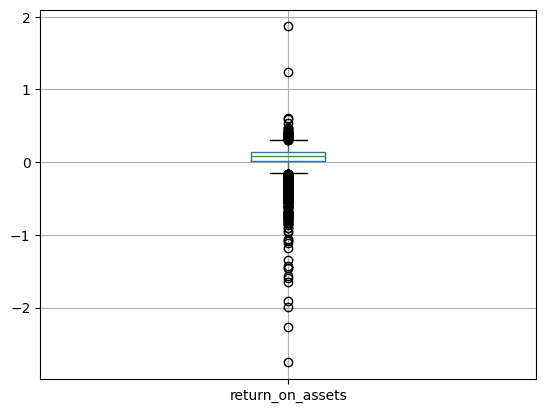

In [ ]:
df3['return_on_assets'] = df3['op_inc_bef_dep']/df3['total_assets']
print(df3['return_on_assets'].describe())
df3.boxplot(column='return_on_assets');

## Removing the outliers

In [ ]:
df3 = df3[(df3['return_on_assets'] > -2) & (df3['return_on_assets'] <= 1)]
print(df3.shape)

(2245, 5)


## Create a binary variable that is 1 if the return on assets ratio is above its median and 0 otherwise.

In [ ]:
df3['high_return_on_assets'] = (df3['return_on_assets'].gt(df3['return_on_assets'].median())).astype(int)
# Display the DataFrame
df3

<ipython-input-235-e33241b858d2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['high_return_on_assets'] = (df3['return_on_assets'].gt(df3['return_on_assets'].median())).astype(int)


,ticker,op_inc_bef_dep,total_assets,description,return_on_assets,high_return_on_assets
0,AIR,179.300,1833.100,AAR Corp. provides products and services to co...,0.097812,1
1,AAL,6267.000,63058.000,"American Airlines Group Inc., through its subs...",0.099385,1
2,PNW,1618.683,24661.153,"Pinnacle West Capital Corporation, through its...",0.065637,0
4,ABT,10036.000,73214.000,"Abbott Laboratories discovers, develops, manuf...",0.137078,1
5,AMD,3881.000,67885.000,"Advanced Micro Devices, Inc. operates as a sem...",0.057170,0
...,...,...,...,...,...,...
2385,APG,771.000,7590.000,"APi Group Corporation provides safety, special...",0.101581,1
2386,NVT,772.300,6161.700,"nVent Electric plc designs, manufactures, mark...",0.125339,1
2387,ACA,339.400,3577.900,"Arcosa, Inc., together with its subsidiaries, ...",0.094860,1
2388,HYFM,-4.848,507.643,"Hydrofarm Holdings Group, Inc., together with ...",-0.009550,0


In [ ]:
df3=df3.sample(2000, random_state=6887)
df3=df3.reset_index(drop=True)

In [ ]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
# Count the number of tokens in the 'text' column
df3['token_count'] = df3['description'].apply(lambda x: len(word_tokenize(x)))
print(df3.shape)
df3

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


(2000, 7)


,ticker,op_inc_bef_dep,total_assets,description,return_on_assets,high_return_on_assets,token_count
0,PGNY,64.465,756.620,"Progyny, Inc., a benefits management company, ...",0.085201,1,123
1,PGEN,-82.255,151.043,"Precigen, Inc. discovers and develops the next...",-0.544580,0,308
2,INSP,-37.425,676.811,"Inspire Medical Systems, Inc., a medical techn...",-0.055296,0,105
3,LUV,2387.000,36487.000,Southwest Airlines Co. operates as a passenger...,0.065421,0,248
4,SRPT,-223.427,3264.576,"Sarepta Therapeutics, Inc., a commercial-stage...",-0.068440,0,249
...,...,...,...,...,...,...,...
1995,SLM,1089.448,29169.468,"SLM Corporation, through its subsidiaries, ori...",0.037349,0,90
1996,VAPO,-32.828,77.617,"Vapotherm, Inc., a medical technology company,...",-0.422949,0,235
1997,LYV,1569.373,19074.045,"Live Nation Entertainment, Inc. operates as a ...",0.082278,1,324
1998,VCYT,10.314,1114.906,"Veracyte, Inc. operates as a genomic diagnosti...",0.009251,0,218


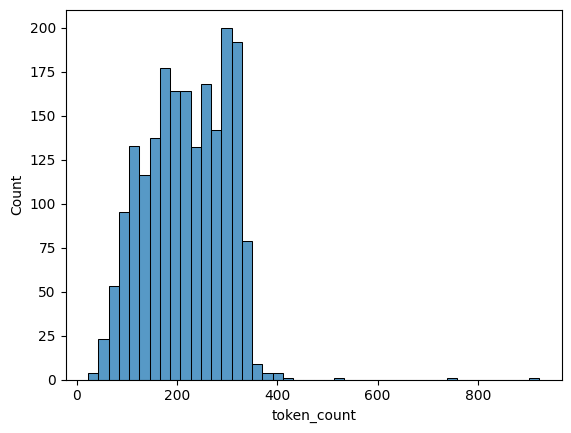

In [ ]:
import seaborn as sns
sns.histplot(data=df3, x="token_count");

In [ ]:
import re
# Function to remove unusual characters
def remove_unusual_characters(text):
    pattern = r'[^a-zA-Z0-9.,?! ]'  # Pattern to match common English characters, numbers, and punctuation
    text = re.sub(pattern, '', text)
    return text

# Apply the function to the 'text' column
df3['text'] = df3['description'].apply(remove_unusual_characters)

In [ ]:
# Remove very long descriptions
lower_threshold = df3['token_count'].quantile(0.00)
upper_threshold = df3['token_count'].quantile(0.99)

# Trim the DataFrame based on the 1% thresholds
trimmed_df3 = df3[(df3['token_count'] >= lower_threshold) & (df3['token_count'] <= upper_threshold)]

trimmed_df3

,ticker,op_inc_bef_dep,total_assets,description,return_on_assets,high_return_on_assets,token_count,text
0,PGNY,64.465,756.620,"Progyny, Inc., a benefits management company, ...",0.085201,1,123,"Progyny, Inc., a benefits management company, ..."
1,PGEN,-82.255,151.043,"Precigen, Inc. discovers and develops the next...",-0.544580,0,308,"Precigen, Inc. discovers and develops the next..."
2,INSP,-37.425,676.811,"Inspire Medical Systems, Inc., a medical techn...",-0.055296,0,105,"Inspire Medical Systems, Inc., a medical techn..."
3,LUV,2387.000,36487.000,Southwest Airlines Co. operates as a passenger...,0.065421,0,248,Southwest Airlines Co. operates as a passenger...
4,SRPT,-223.427,3264.576,"Sarepta Therapeutics, Inc., a commercial-stage...",-0.068440,0,249,"Sarepta Therapeutics, Inc., a commercialstage ..."
...,...,...,...,...,...,...,...,...
1995,SLM,1089.448,29169.468,"SLM Corporation, through its subsidiaries, ori...",0.037349,0,90,"SLM Corporation, through its subsidiaries, ori..."
1996,VAPO,-32.828,77.617,"Vapotherm, Inc., a medical technology company,...",-0.422949,0,235,"Vapotherm, Inc., a medical technology company,..."
1997,LYV,1569.373,19074.045,"Live Nation Entertainment, Inc. operates as a ...",0.082278,1,324,"Live Nation Entertainment, Inc. operates as a ..."
1998,VCYT,10.314,1114.906,"Veracyte, Inc. operates as a genomic diagnosti...",0.009251,0,218,"Veracyte, Inc. operates as a genomic diagnosti..."


In [ ]:
trimmed_df3=trimmed_df3[trimmed_df3["ticker"]!="LLY"] # these 2 have special characters in description, hence removed
trimmed_df3=trimmed_df3[trimmed_df3["ticker"]!="BIIB"]
trimmed_df3=trimmed_df3.reset_index(drop=True)

In [ ]:
from nltk.tokenize import sent_tokenize
# Function to keep first three sentences
def keep_n_sentences(text):
    sentences = sent_tokenize(text)
    first_three_sentences = sentences[:1]
    return ' '.join(first_three_sentences)

# Apply the function to the 'text' column
trimmed_df3['text'] = trimmed_df3['text'].apply(keep_n_sentences)

In [ ]:
trimmed_df3.head(3)

,ticker,op_inc_bef_dep,total_assets,description,return_on_assets,high_return_on_assets,token_count,text
0,PGNY,64.465,756.620,"Progyny, Inc., a benefits management company, ...",0.085201,1,123,"Progyny, Inc., a benefits management company, ..."
1,PGEN,-82.255,151.043,"Precigen, Inc. discovers and develops the next...",-0.544580,0,308,"Precigen, Inc. discovers and develops the next..."
2,INSP,-37.425,676.811,"Inspire Medical Systems, Inc., a medical techn...",-0.055296,0,105,"Inspire Medical Systems, Inc., a medical techn..."


##Preparing the predictor and DistilBERT model

In [ ]:
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights, max_length=2)
model = model_class.from_pretrained(pretrained_weights)

## Tokenize the textual data for DistilBERT

In [ ]:
trimmed_df3.description[12]

'PTC Inc. operates as software and services company in the Americas, Europe, and the Asia Pacific. The company operates in two segments, Software Products and Professional Services. It offers ThingWorx, an IIoT platform that enables customers to address digital transformation of their operations, products, and services; ThingWorx Solution Central, a centralized portal in the cloud that allows users of ThingWorx to discover, deploy, and manage ThingWorx applications; and ThingWorx Kepware, which enables users to connect, manage, monitor, and control disparate devices and software applications. The company also provides Vuforia Studio, a cloud-based tool that enables industrial enterprises to author and publish augmented reality (AR) experiences; Vuforia Expert Capture that chronicles the real-time movements of a person wearing an AR headset; Vuforia Engine technology for application development; Vuforia Chalk, a collaboration and remote assistance solution; and Vuforia Spatial Toolbox t

In [ ]:
trimmed_df3.text[12]

'PTC Inc. operates as software and services company in the Americas, Europe, and the Asia Pacific.'

In [ ]:
tokenized3 = trimmed_df3['text'].apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

## Pad all lists of tokenized values to the same size

In [ ]:
max_len = 0
for i in tokenized1.values:
    if len(i) > max_len:
        max_len = len(i)

padded3 = np.array([i + [0]*(max_len-len(i)) for i in tokenized3.values])

In [ ]:
np.array(padded3).shape

(1979, 100)

In [ ]:
attention_mask = np.where(padded3 != 0, 1, 0)
attention_mask.shape

(1979, 100)

## DistilBERT model

In [ ]:
input_ids = torch.tensor(padded3)
attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids,
                               attention_mask=attention_mask)

## Logistic Regression Model

In [ ]:
trimmed_df3

,ticker,op_inc_bef_dep,total_assets,description,return_on_assets,high_return_on_assets,token_count,text
0,PGNY,64.465,756.620,"Progyny, Inc., a benefits management company, ...",0.085201,1,123,"Progyny, Inc., a benefits management company, ..."
1,PGEN,-82.255,151.043,"Precigen, Inc. discovers and develops the next...",-0.544580,0,308,"Precigen, Inc. discovers and develops the next..."
2,INSP,-37.425,676.811,"Inspire Medical Systems, Inc., a medical techn...",-0.055296,0,105,"Inspire Medical Systems, Inc., a medical techn..."
3,LUV,2387.000,36487.000,Southwest Airlines Co. operates as a passenger...,0.065421,0,248,Southwest Airlines Co. operates as a passenger...
4,SRPT,-223.427,3264.576,"Sarepta Therapeutics, Inc., a commercial-stage...",-0.068440,0,249,"Sarepta Therapeutics, Inc., a commercialstage ..."
...,...,...,...,...,...,...,...,...
1974,SLM,1089.448,29169.468,"SLM Corporation, through its subsidiaries, ori...",0.037349,0,90,"SLM Corporation, through its subsidiaries, ori..."
1975,VAPO,-32.828,77.617,"Vapotherm, Inc., a medical technology company,...",-0.422949,0,235,"Vapotherm, Inc., a medical technology company,..."
1976,LYV,1569.373,19074.045,"Live Nation Entertainment, Inc. operates as a ...",0.082278,1,324,"Live Nation Entertainment, Inc. operates as a ..."
1977,VCYT,10.314,1114.906,"Veracyte, Inc. operates as a genomic diagnosti...",0.009251,0,218,"Veracyte, Inc. operates as a genomic diagnosti..."


In [ ]:
features3 = last_hidden_states[0][:,0,:].numpy()
labels3 = trimmed_df3['high_return_on_assets']

In [ ]:
features3

array([[-0.4685655 , -0.15254568, -0.26088962, ..., -0.1099144 ,
         0.29823437,  0.52396923],
       [-0.3924973 , -0.21256879, -0.14517824, ..., -0.29499143,
         0.29298133,  0.3116078 ],
       [-0.48038805, -0.18228008, -0.28914028, ..., -0.09028091,
         0.25982305,  0.3063024 ],
       ...,
       [-0.28240833, -0.05231728, -0.13909516, ..., -0.05405312,
         0.5296694 ,  0.33160532],
       [-0.3738006 , -0.1388223 , -0.33005032, ..., -0.08191945,
         0.42910266,  0.49709412],
       [-0.24719869, -0.00574954, -0.16402751, ...,  0.09633833,
         0.5788754 ,  0.36579853]], dtype=float32)

In [ ]:
train_features, test_features, train_labels, test_labels = train_test_split(features3, labels3, random_state=42)
lr_rar = LogisticRegression(max_iter=5000)
lr_rar.fit(train_features, train_labels)
print(lr_rar.score(test_features, test_labels))

0.7494949494949495


In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Dummy classifier score: 0.503 (+/- 0.00)


## Analysis of Return on Assets Ratio

The term return on assets (ROA) refers to a financial ratio that indicates how profitable a company is in relation to its total assets. Corporate management, analysts, and investors can use ROA to determine how efficiently a company uses its assets to generate a profit.

- Return on assets is a metric that indicates a company's profitability in relation to its total assets.
- ROA can be used by management, analysts, and investors to determine whether a company uses its assets efficiently to generate a profit.
- ROA factors in a company's debt while return on equity does not.

A ROA of over 5% is generally considered good and over 20% excellent. However, ROAs should always be compared amongst firms in the same sector. For instance, a software maker has far fewer assets on the balance sheet than a car maker. As a result, the software company's assets will be understated and its ROA may get a questionable boost.

From the boxplot, in the dataset around 5 outliers have been dropped. For calculating high ROA variable, we filter it on the basis median to get a balanced proportion.

**Performance Evaluation:**
The logistic regression model achieves an accuracy of approximately 74.9% on the test set. Accuracy measures the proportion of correctly predicted instances out of the total number of instances in the test set. While this accuracy indicates that the model performs better than random guessing, it suggests that there is room for improvement in distinguishing between companies with high and low return on assets based on textual descriptions alone.